In [1]:
# import standard libraries
from  dateutil import relativedelta
import math
import regex as re
from glob import glob
import numpy as np
import random
# third-party libraries
import dask
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
# local libraries
from fbd import read_parquet, get_monthly_returns

In [2]:
# get reproducible results
random.seed(0)
np.random.seed(0)

# Settings

In [3]:
# choose cluster method
cluster_method = ['kmeans', 'agglomerative_ward', 
                  'meanshift', 'spectral'][3]

In [4]:
# choose factor model
num_feat = 8

In [5]:
# transaction costs
cost = 0 #0.3/10000 # in basis points

# Data 

In [6]:
# get constituents
const_mat = pd.read_csv('data/russell3000.csv.gz', compression='gzip',
                        index_col=0)

In [7]:
# get clusters
info_labels = read_parquet(f'data/clustering/{num_feat}_factor/{cluster_method}.parquet')

In [8]:
info = info_labels[['comnam', 'naics', 'ticker', 'sector']]
labels = info_labels.drop(columns=info.columns)

In [9]:
# get fama
fama = pd.read_csv('data/fama/fama.csv.gz', compression='gzip', index_col=0)/100
fama = fama[fama.index.isin(labels.columns.values)]

# Trading strategy

In [10]:
%%time
# intial returns of portfolios daily
results = pd.DataFrame(index=labels.columns.values, 
                       columns=['best cluster', 'worse cluster', 'Russell 3000', 'random strategy']
                      )

# intialization
month_ret = ''
returns = pd.DataFrame()
i = 0
long_securities_prev = set()
short_securities_prev = set()
for t in tqdm(labels.columns.values):
    # read two month returns at a time only when necessary
    month_t = t[:7]
    if month_ret != month_t:
        returns = get_monthly_returns(month_t, const_mat, months=2)
        month_ret = month_t
        # get window size
        #month_t_1 = (pd.to_datetime(month_t) - relativedelta.relativedelta(months=1)).strftime('%Y-%m')
        #w = returns.index.str.startswith(month_t_1).sum()
    
    # get equally-weighted returns of each cluster at time t-1
    # the returns of portfolios at t-1 will be a signal for the 
    # long portfolio to choose at time t
    clusters = labels[t].dropna()
    clusters_ewr = pd.Series(index=clusters.unique(), data=clusters.unique())
    # get index t-1 and t-w
    t_1 = returns.index[np.where(returns.index==t)[0]-1][0]
    #t_w = returns.index[np.where(returns.index==t)[0]-w][0]
    #clusters_ewr = clusters_ewr.apply(lambda x: returns.loc[t_w:t_1, clusters[clusters==x].index.values].mean().mean())
    clusters_ewr = clusters_ewr.apply(lambda x: returns.loc[t_1, clusters[clusters==x].index.values].mean())
    
    # determine cluster to long
    long_c = clusters_ewr.idxmax()
    short_c = clusters_ewr.idxmin()
    
    # get equally-weighted returns of long cluster at time t
    # allocate 100% of capital in portfolio
    long_securities = clusters[clusters==long_c].index.values
    long_ret = returns.loc[t, long_securities].mean()
    
    short_securities = clusters[clusters==short_c].index.values
    short_ret = returns.loc[t, short_securities].mean()
    
    # sometimes, not enough elements in a cluster to form a return
    while math.isnan(long_ret):
        clusters_ewr.drop(long_c, inplace=True)
        long_c = clusters_ewr.idxmax()
        long_securities = clusters[clusters==long_c].index.values
        long_ret = returns.loc[t, long_securities].mean()
        
    while math.isnan(short_ret):
        clusters_ewr.drop(short_c, inplace=True)
        short_c = clusters_ewr.idxmin()
        short_securities = clusters[clusters==short_c].index.values
        short_ret = returns.loc[t, short_securities].mean()
        
    # make a random Russell 3000, select x random securities from index, where x is number of securities in
    # cluster to long
    len_c = len(clusters[clusters==long_c])
    random_ret = returns.loc[t].dropna()
    random_ret = random_ret.sample(len_c).mean()
    
    # general Russell 3000 ret
    russell_ret = returns.loc[t].mean()
    
    #if math.isnan(long_ret) or math.isnan(russell_ret):
    #    break
    
    # compute costs of strategy
    # a trade is considered either a buy or sell.
    long_buy_cost = len(set(long_securities) - long_securities_prev)*cost
    long_sell_cost = len(long_securities_prev - set(long_securities))*cost
    long_securities_prev = set(long_securities)
    
    short_buy_cost = len(set(short_securities) - short_securities_prev)*cost
    short_sell_cost = len(short_securities_prev - set(short_securities))*cost
    short_securities_prev = set(short_securities)
    
    results.at[t, 'best cluster'] = long_ret - (long_buy_cost + long_sell_cost)
    results.at[t, 'worse cluster'] = short_ret - (short_buy_cost + short_sell_cost)
    results.at[t, 'Russell 3000'] = russell_ret
    results.at[t, 'random strategy'] = random_ret

100%|██████████| 2497/2497 [00:59<00:00, 42.04it/s]

CPU times: user 1min 14s, sys: 7.49 s, total: 1min 22s
Wall time: 59.4 s


In [11]:
#add market to dataframe of capital
results['market'] = fama['Mkt-RF'] + fama['RF']

In [12]:
# save results
filename = f'data/strategy/{num_feat}_factor/{cluster_method}_{int(math.ceil(cost*1e6))}.gz'
results.to_csv(filename ,compression='gzip')

In [13]:
# do cumulative returns from a capital of 1$
capital = results + 1
# add bogus date with 1 at the beginnninng
capital = pd.concat([pd.DataFrame(columns=capital.columns, index=['2010-01-31'], data=1), capital], 
                    axis=0, 
                    ignore_index=False)
capital = capital.cumprod()

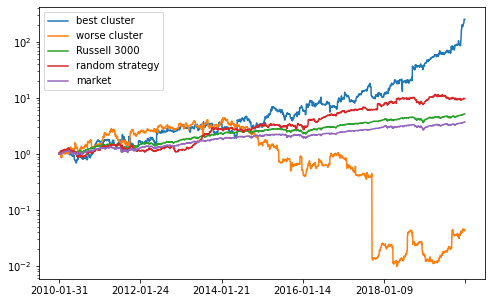

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
capital.plot(ax=ax)
ax.set_yscale('log')